In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [2]:
if torch.cuda.is_available():  
    DEVICE = "cuda:0"
    print('Using cuda!')
    print(torch.cuda.current_device())
else:
    DEVICE = "cpu"
DEVICE

Using cuda!
0


'cuda:0'

In [3]:
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

train_dir = './ImageEmotionDatasetMid/train'
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

train_dataset.classes

['amusement',
 'anger',
 'awe',
 'contentment',
 'disgust',
 'excitement',
 'fear',
 'sadness']

In [4]:
len(train_dataset)

1501

In [5]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

In [6]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# don't freeze model
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model_conv = model_conv.to(DEVICE)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [8]:
epochs = 25

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model_conv(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # stats
        running_loss += loss.item()
    
    # end of epoch
    print(f'Epoch {epoch} - loss: {running_loss}')
    scheduler.step(loss)

print('Finished training')

Epoch 0 - loss: 159.67939174175262
Epoch 1 - loss: 124.65208959579468
Epoch 2 - loss: 115.79522562026978
Epoch 3 - loss: 108.34765350818634
Epoch 4 - loss: 103.10633632540703
Epoch 5 - loss: 98.17276614904404
Epoch 6 - loss: 92.17609226703644
Epoch 7 - loss: 94.79989913105965
Epoch 8 - loss: 92.22990533709526
Epoch 9 - loss: 86.36721202731133
Epoch 10 - loss: 86.34824028611183
Epoch 11 - loss: 81.43114274740219
Epoch 12 - loss: 79.64961040019989
Epoch 13 - loss: 79.23513862490654
Epoch 14 - loss: 80.67793011665344
Epoch 15 - loss: 82.18969371914864
Epoch 16 - loss: 78.40297594666481
Epoch 17 - loss: 78.80871203541756
Epoch 18 - loss: 74.36874547600746
Epoch 19 - loss: 72.30589689314365
Epoch 20 - loss: 70.83842712640762
Epoch 21 - loss: 74.24931356310844
Epoch 22 - loss: 68.66937524080276
Epoch 23 - loss: 69.89259821176529
Epoch 24 - loss: 73.68698564171791
Finished training


In [17]:
save_dir = './test_model_resnet.pth'
torch.save(model_conv.fc, save_dir)

In [9]:
test_dir = './ImageEmotionDatasetMid/test'
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

test_dataset.classes

['amusement',
 'anger',
 'awe',
 'contentment',
 'disgust',
 'excitement',
 'fear',
 'sadness']

In [10]:
# copied this from the sample lol
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [11]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

In [12]:
len(test_dataset)

385

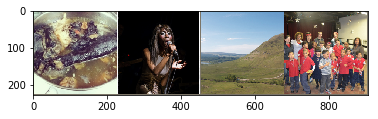

Ground Truth:  disgust excitement   awe excitement


In [13]:
dataiter = iter(test_loader)

images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' % test_dataset.classes[labels[j]] for j in range(4)))

In [14]:
with torch.no_grad():
    outputs = model_conv(images.to(DEVICE))
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % train_dataset.classes[predicted[j]] for j in range(4)))

Predicted:  disgust sadness   awe excitement


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on all test images: %d %%' % (100 * correct / total))

Accuracy of the network on all test images: 42 %


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on all train images: %d %%' % (100 * correct / total))

Accuracy of the network on all train images: 77 %


lmao completely overfitted

=== DEMO ===

In [ ]:
model_conv.eval()
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

testImage = datasets.ImageFolder('./', transform=transform)
demoLoader = DataLoader(testImage, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(demoLoader)
image, label = dataiter.next()
imshow(torchvision.utils.make_grid(image))
image = image.to(DEVICE)
outputs = model_conv(image)
_, predicted = torch.max(outputs.data, 1)
print(predicted)
print(test_dataset.classes[predicted[0]])